# AI - MLP Project

## Universal Function Approximator

Ahmad Salimi

At first, import required libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
import inspect
from sys import stdout
import multiprocessing as mp

### Loss history callback

This class, stores loss and learning rate history and prints log.

In [3]:
class LossHistory(keras.callbacks.Callback):

    def __init__(self, learner):
        self.learner = learner
        self.epoch = 1

    def on_train_begin(self, logs={}):
        self.data = {'loss': [], 'lr': []}
    
    def on_epoch_end(self, batch, logs={}):
        self.data['loss'].append(logs.get('loss'))
        self.data['lr'].append(self.learner.lr)

        if self.epoch % 20 == 0:
            self.learner.print_status(self.epoch, logs.get('loss'))
        self.epoch += 1

### Function Learner

This class, uses MLP neural networks to approximate a function. Execution Steps are as explaned below:

1. Initialize:
    
    1. Initialize training dataset: There's 2 approaches to initialize dataset:

        - Given a trainig dataset: just use the given dataset
        - Given a function, domain of each axis, and size of training dataset: create a uniformly distributed dataset according to the given parameters
    
    1. Add noise to dataset if it's given
    
    1. Normalize dataset with a MinMaxScaler
    
    1. Create Model: The neural network model has two hidden layers, each with given neurons and their activation function is relu, and an output layer with 1 neuron. the loss function is MSE, and it uses Adam optimizer.
    
    1. Fit the model: The model starts fitting using train data and given epochs. The learning rate decreases every 500 epochs. The validation split is 0.1.

In [15]:
class FunctionLearner:
    
    def __init__(self, train_data=None, function=None, data_size=None, train_domain_low=None, train_domain_high=None, neurons=[20, 20], activations=['relu', 'relu'], noise_sigma=None):
        self.function = function
        self.feature_scaler = MinMaxScaler()
        self.target_scaler = MinMaxScaler()
        self.X, self.y = self.get_dataset(train_data, data_size, train_domain_low, train_domain_high, noise_sigma)
        self.model = self.create_model(neurons, activations)
        self.lr = 0.01
        self.alpha = 0.9
    
    def get_feature_dimension(self):
        return len(inspect.signature(self.function).parameters)
    
    def get_dataset(self, data, size:int, low, high, noise_sigma):
        if data is not None:
            X = data[data.columns[:-1]].values
            y = data[data.columns[-1:]].values
            self.function = lambda x: y if x is X else None
        else:
            X, y = self.create_random_dataset(size, low, high, noise_sigma)

        self.feature_scaler.fit(X)
        self.target_scaler.fit(y)
        return X, y
    
    def create_random_dataset(self, size:int, low, high, noise_sigma):
        feature_shape = (size, self.get_feature_dimension())
        X = np.random.uniform(low, high, feature_shape)
        y = self.function(*X.T).reshape(size, 1)

        if noise_sigma:
            y += np.random.normal(scale=noise_sigma, size=(size, 1))
        return X, y

    def step_decay(self, epoch):
        if epoch % 500 == 0:
            self.lr *= 0.9
        return self.lr
    
    def create_model(self, neurons, activations):
        model = Sequential()
        model.add(Dense(neurons[0], input_dim=self.get_feature_dimension(), activation=activations[0], kernel_initializer='he_uniform'))
        model.add(Dense(neurons[0], activation=activations[1], kernel_initializer='he_uniform'))
        model.add(Dense(1))

        opt = keras.optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=opt, loss='mse')
        return model

    def plot_axis(self, x, axis, title=None):
        plt.figure(figsize=(15, 10))

        if title:
            plt.title(title)
        
        plt.scatter(x[:, axis], self.predict(x).reshape(x.shape[0],) - self.function(*x.T), color='red', label='prediction error', s=5, zorder=1)
        plt.scatter(self.X[:, axis], self.y.reshape(self.X.shape[0],) - self.function(*self.X.T), color='green', label='train error', s=5, zorder=2)

        plt.grid()
        plt.legend()
    
    def plot_result(self, x, title=None, xlim=None, ylim=None):
        if self.get_feature_dimension() > 1:
            raise Exception("Cannot plot more than 2d")
        
        plt.figure(figsize=(15, 10))

        if title:
            plt.title(title)
        
        plt.scatter(x, self.function(x), color='skyblue', label='original', s=90, zorder=1)
        plt.scatter(self.X, self.y, color='green', label='train data', s=50, zorder=2)
        plt.scatter(x, self.predict(x), color='red', label='predicted', s=5, zorder=3)
        plt.grid()
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
        plt.legend()

    def plot_history(self, name, ylim=None):
        plt.figure(figsize=(15, 10))
        plt.plot(np.arange(len(self.loss_history.data[name])), self.loss_history.data[name], color='skyblue', label=name, linewidth=3, zorder=1)
        plt.grid()
        if ylim:
            plt.ylim(ylim)
        plt.legend()
    
    def print_status(self, epoch, loss):
        stdout.write(f"\repoch: {epoch:4} - loss: {loss:.5e}")
        stdout.flush()
    
    def learn(self, epochs):
        learning_rate = LearningRateScheduler(self.step_decay)
        self.loss_history = LossHistory(self)

        self.model.fit(
            self.feature_scaler.transform(self.X), 
            self.target_scaler.transform(self.y), 
            batch_size=10, epochs=epochs, 
            callbacks=[self.loss_history, learning_rate], 
            verbose=0, validation_split=0.1)

        self.print_status(epochs, self.loss_history.data["loss"][-1])
        print()
    
    def mse(self, X, Y):
        return ((X - Y) ** 2).mean()

    def error(self, X):
        prediction = self.predict(X)
        return self.mse(prediction, self.function(*X.T).reshape(prediction.shape))
    
    def predict(self, X):
        return self.target_scaler.inverse_transform(
            self.model.predict(
                self.feature_scaler.transform(X)))

### $\S1.$ Samples in $f: \mathbb{R} \to \mathbb{R}$

$$f(x) = 554x + 2$$

In [16]:
learner = FunctionLearner(
    function=lambda x: 554 * x + 2, 
    data_size=20, 
    train_domain_low=-10, 
    train_domain_high=10, 
    neurons=[4, 1],
    activations=['linear', 'linear'])

In [17]:
learner.learn(500)

epoch:  500 - loss: 1.05244e-14


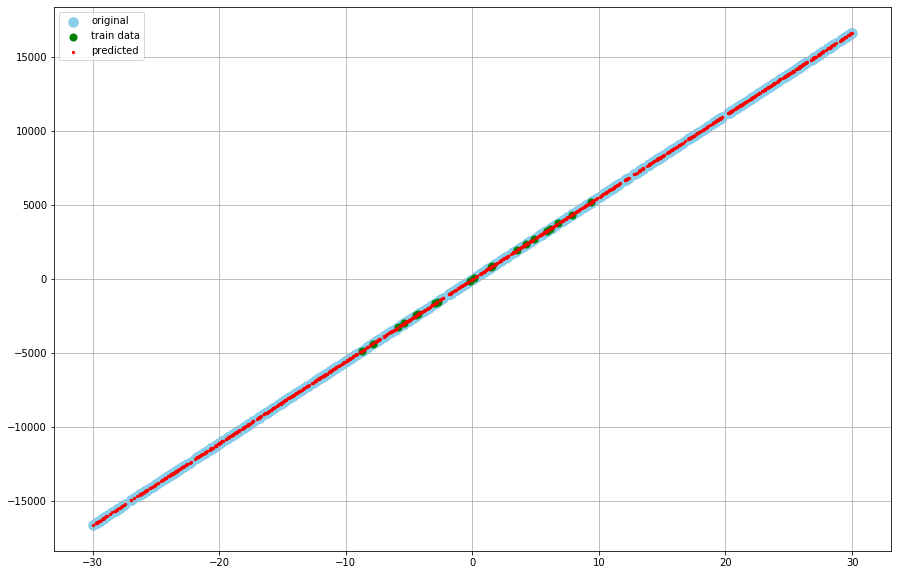

In [18]:
learner.plot_result(np.random.uniform(-30, 30, (1000, 1)))

$$f(x) = \sin(x)$$

In [24]:
learner = FunctionLearner(
    function=lambda x: np.sin(x),
    data_size=200,
    train_domain_low=-10,
    train_domain_high=10,
    neurons=[20, 20])

In [25]:
learner.learn(2000)

epoch: 2000 - loss: 4.75776e-04


Learning rate and loss diagram in terms of epoch:

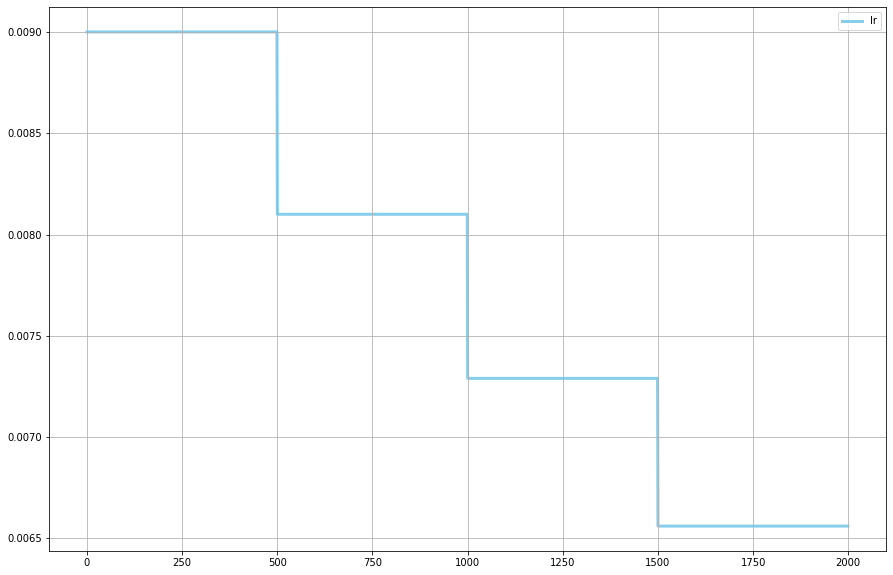

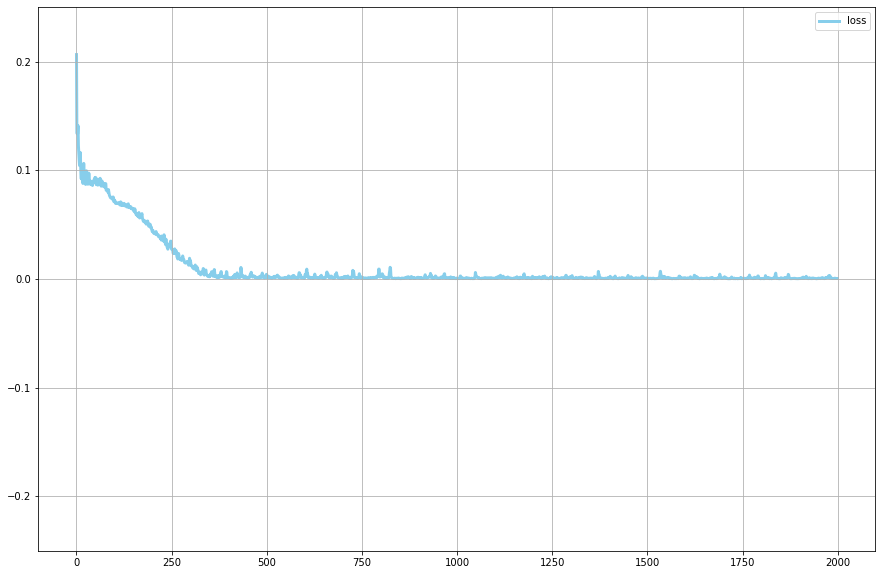

In [26]:
learner.plot_history('lr')
learner.plot_history('loss', ylim=(-.25, .25))

In complex function like this, the model can not be generalized to points outside the domain of the training set. Because if we look at it theoretically, the $\sin(x)$ function can be represented by the Taylor serie, that the more we want to cover a larger range, the more terms we have to compute (in the ideal case we have to compute infinite terms). With a limited number of neorons, the model cannot be generalized to points outside the domain of the training set.

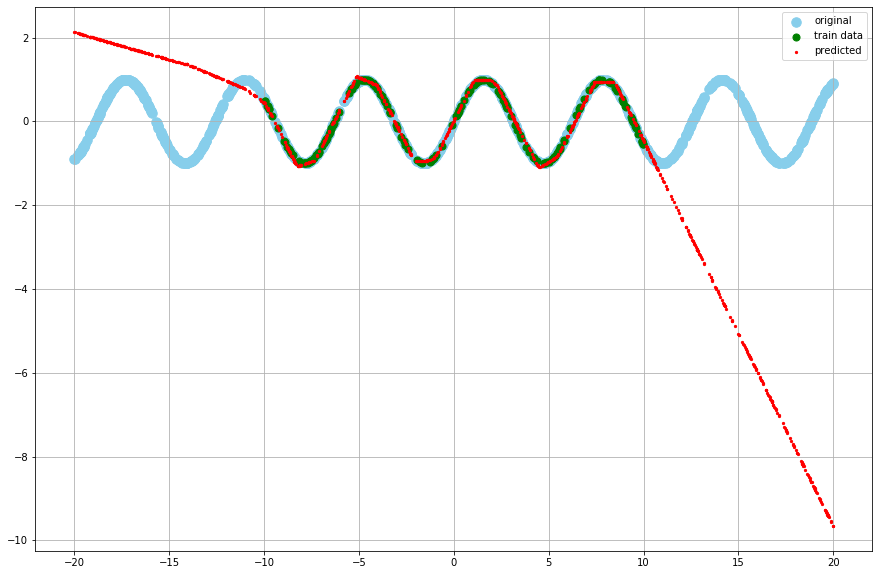

In [27]:
learner.plot_result(np.random.uniform(-20, 20, (1000, 1)))

$$ f(x) = 50x^3 + 2500 $$

In [32]:
learner = FunctionLearner(
    function=lambda x: 50 * x ** 3 + 2500,
    data_size=100,
    train_domain_low=-10,
    train_domain_high=10,
    neurons=[20, 20],
    activations=['relu', 'linear'])

In [33]:
learner.learn(2000)

epoch: 2000 - loss: 1.90507e-04


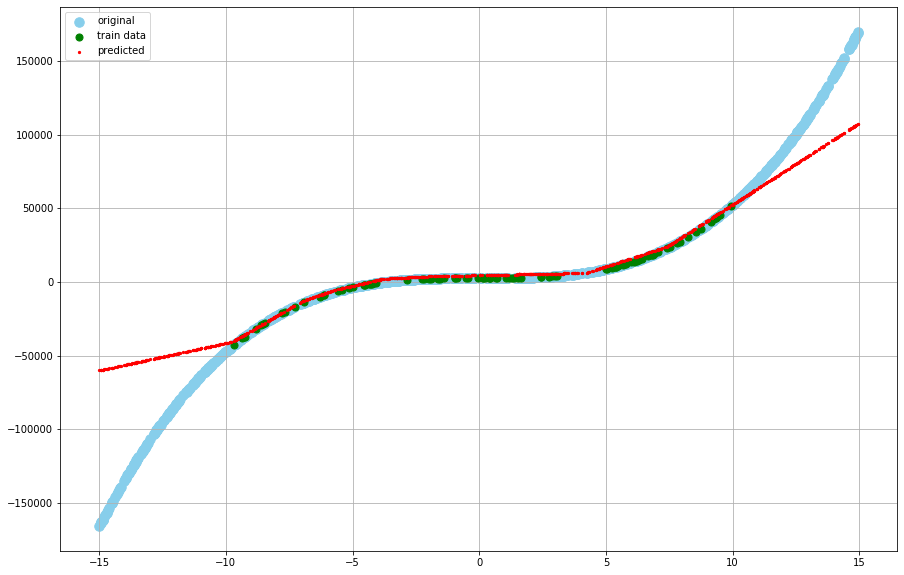

In [34]:
learner.plot_result(np.random.uniform(-15, 15, (1000, 1)))

$$ f(x) = x^2\sin(x) $$

In [216]:
learner = FunctionLearner(
    function=lambda x: x ** 2 * np.sin(x),
    data_size=500,
    train_domain_low=-10,
    train_domain_high=10,
    neurons=[22, 22])

In [217]:
learner.learn(2000)

epoch: 2000 - loss: 6.31920e-04

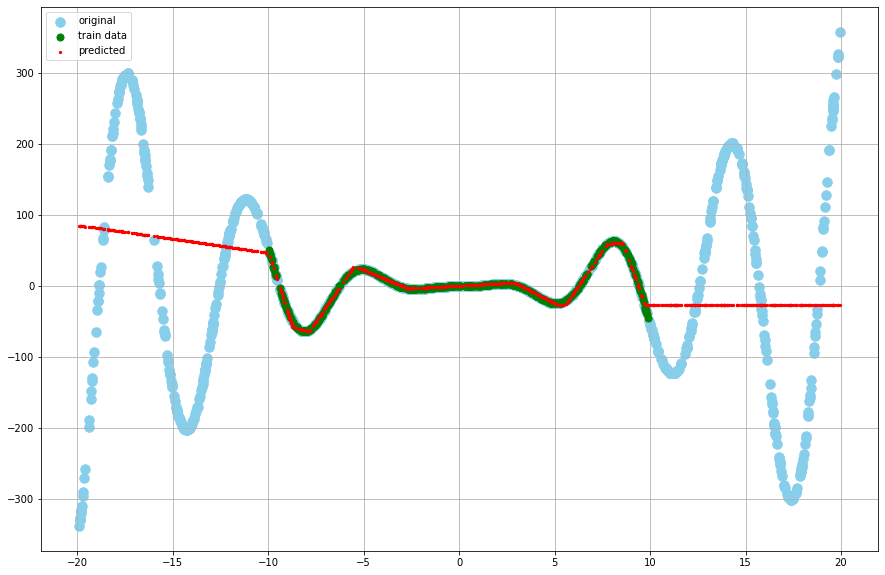

In [218]:
learner.plot_result(np.random.uniform(-20, 20, (1000, 1)))

#### Analyze the relationship between function and model parameters

- Training set size: The training set must cover the critical points of the function, so the more complex the function, the larger the data set needed.
- Number of hidden layers: With two hidden layers any function can be approximated. Increasing the number of layers does not significantly affect the performance of this kind of problems.
- Number of neurons of each layer: The more complex the function, the greater the number of neurons.
- Number of epochs: The more complex the function, the more epochs are required for the model to converge. Although there is usually an optimal point. (From the loss plot you can find a point after which no significant changes in loss are observed)
- Training set domain: In complex functions, the wider the training set, the more difficult it is to learn and the more neurons and epochs are required.

### $\S2.$ Adding noise to dataset

In this section, different noises are added to the training points of the $f(x)=\sin{x}$ function and the result is displayed. Noises in this part are $0.05, 0.1, ... , 0.45$.

start training on noise 0.05
epoch: 3000 - loss: 1.55666e-02
start training on noise 0.1
epoch: 3000 - loss: 2.32464e-03
start training on noise 0.15000000000000002
epoch: 3000 - loss: 3.10383e-02
start training on noise 0.2
epoch: 3000 - loss: 1.75029e-02
start training on noise 0.25
epoch: 3000 - loss: 3.15726e-02
start training on noise 0.3
epoch: 3000 - loss: 7.88643e-03
start training on noise 0.35000000000000003
epoch: 3000 - loss: 1.74380e-02
start training on noise 0.4
epoch: 3000 - loss: 1.77790e-02
start training on noise 0.45
epoch: 3000 - loss: 2.27295e-02


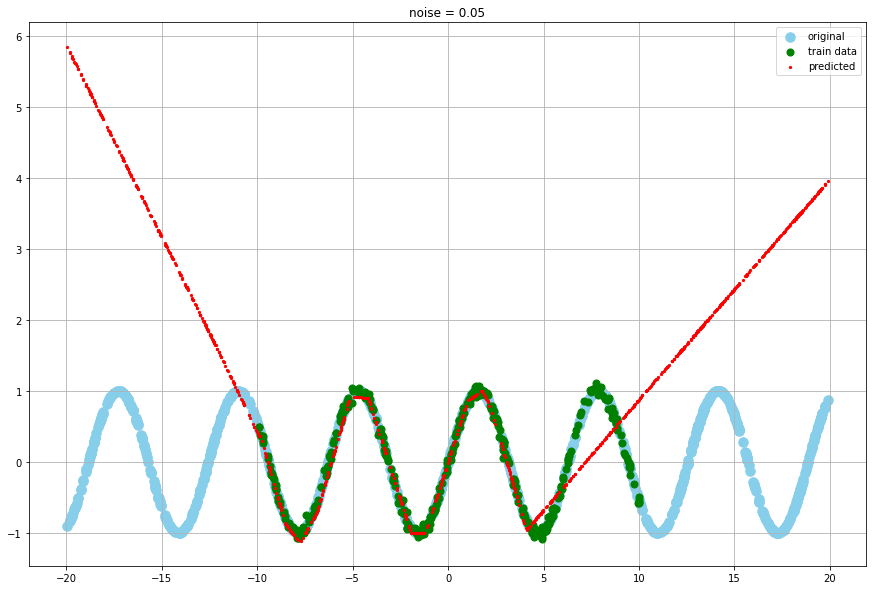

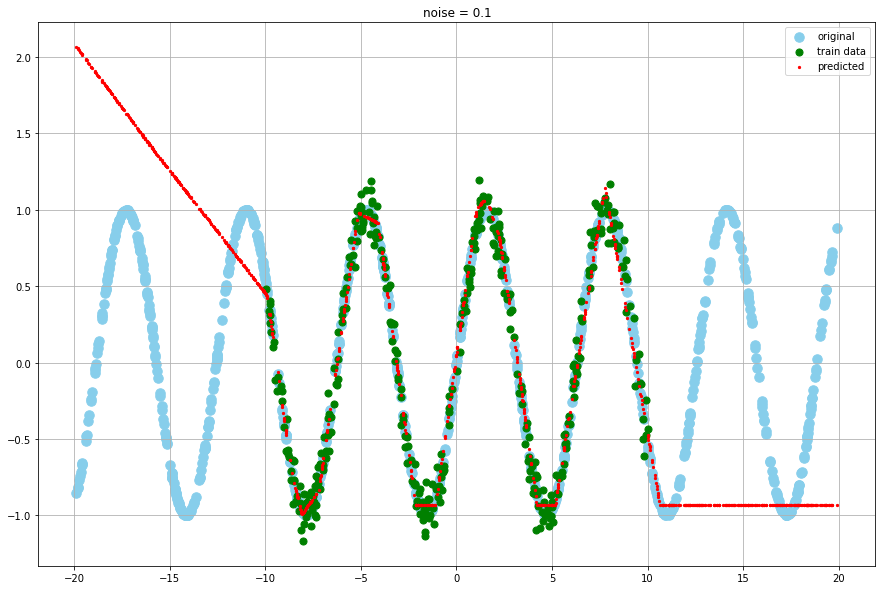

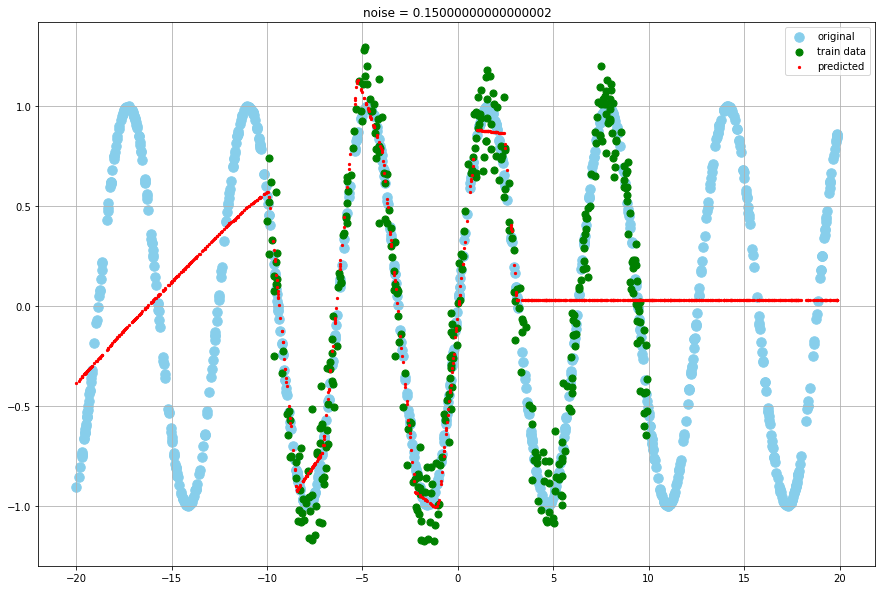

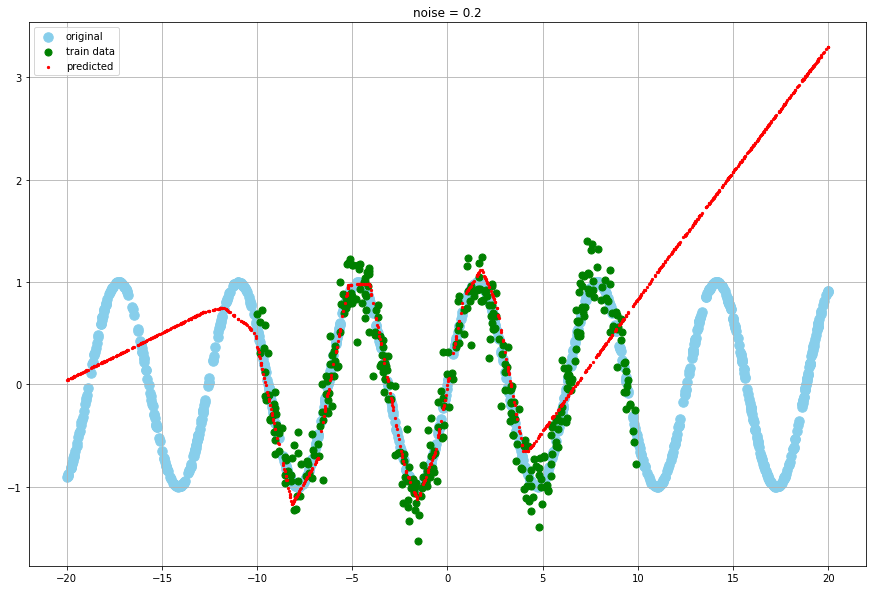

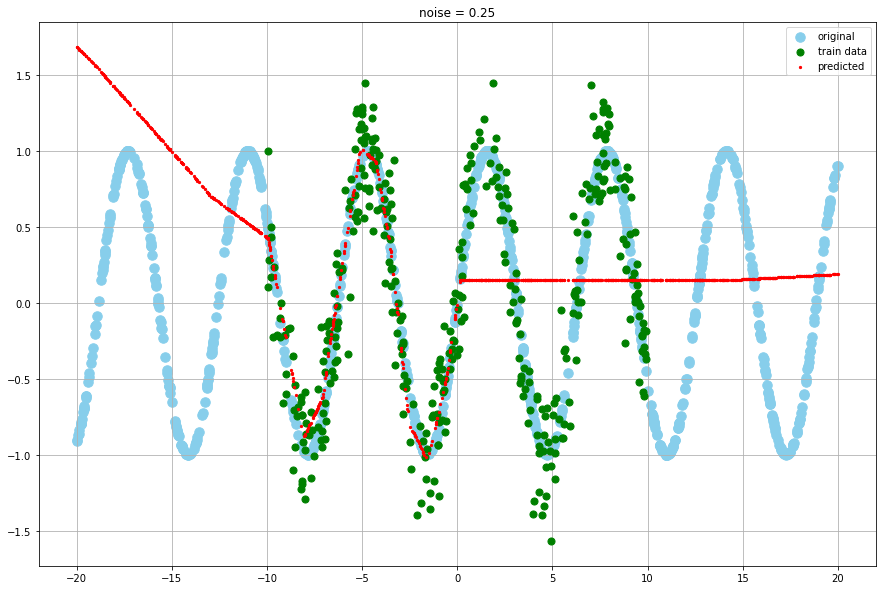

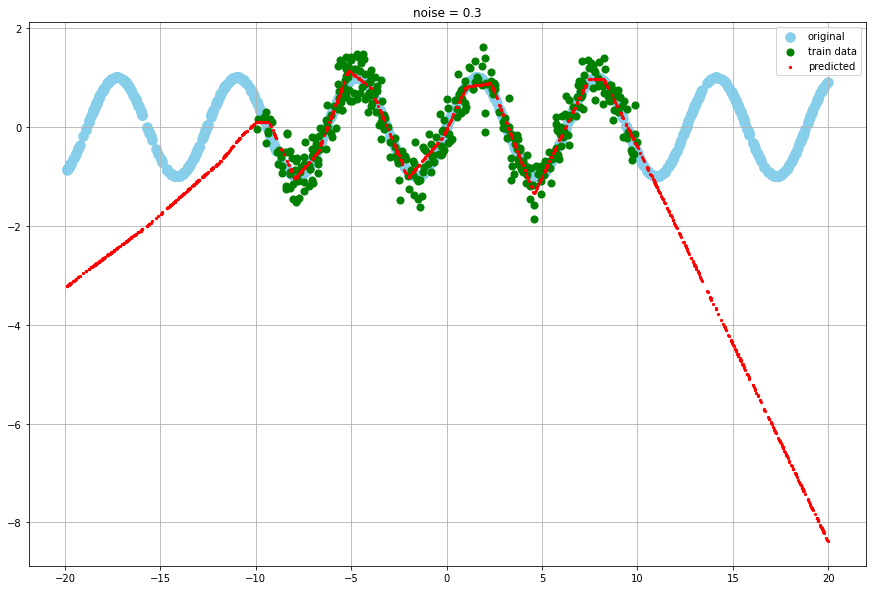

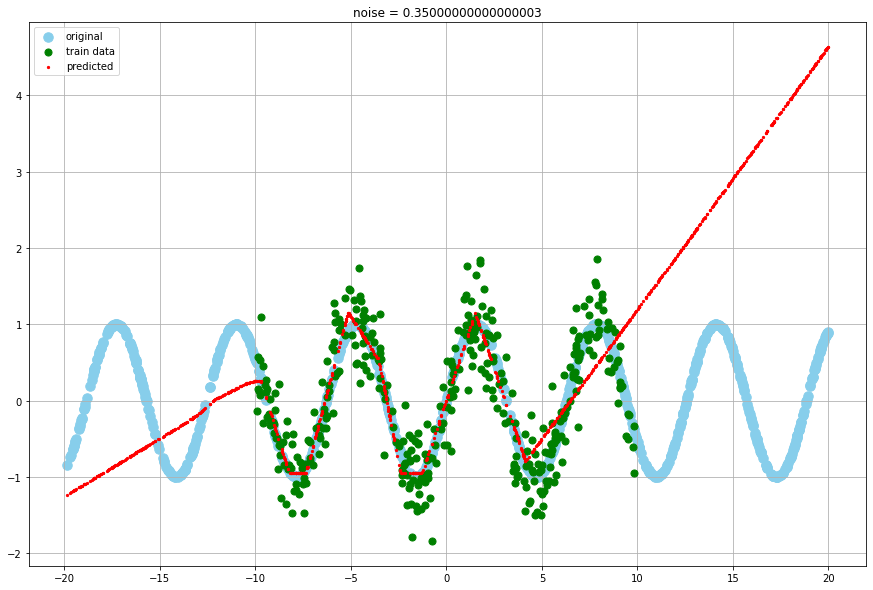

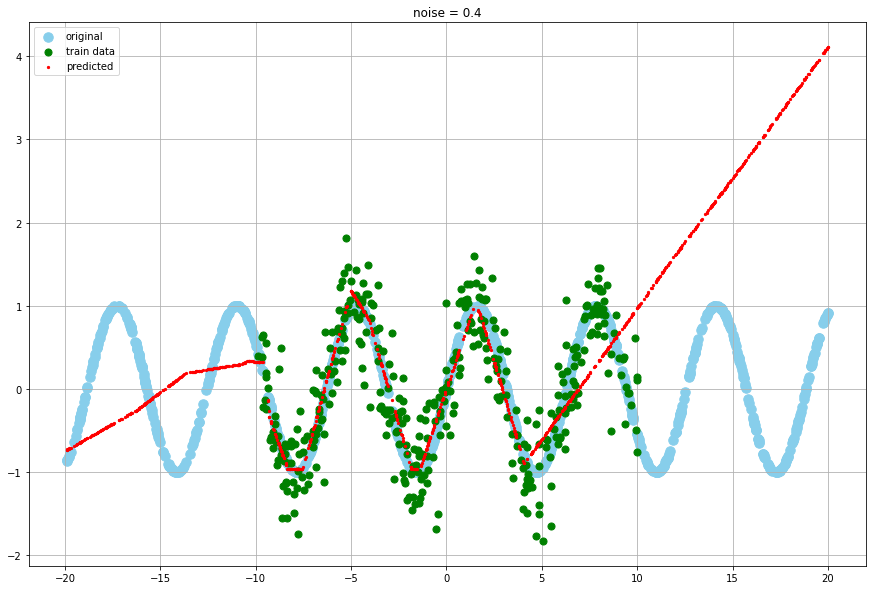

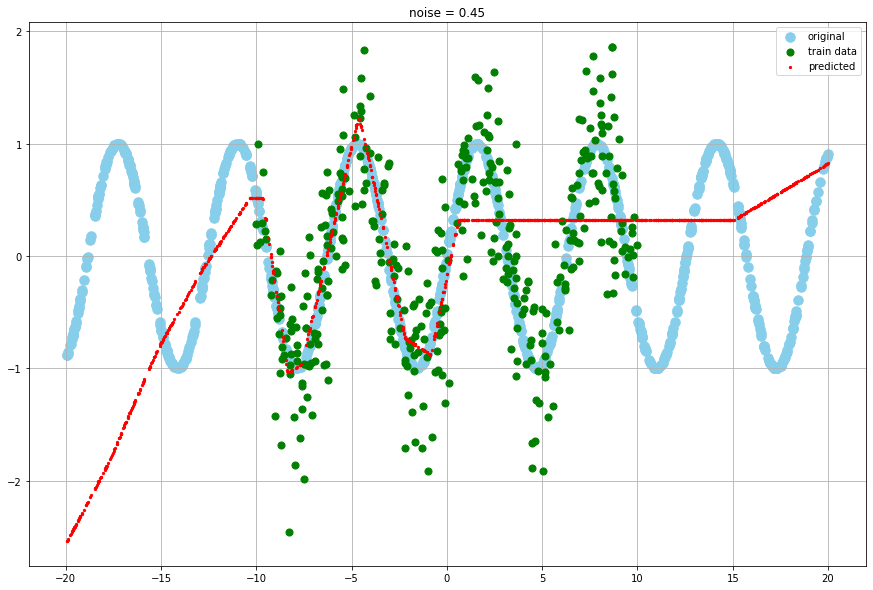

In [10]:
for noise in np.arange(0.05, 0.5, 0.05):
    print(f'start training on noise {noise}')
    
    learner = FunctionLearner(
        function=lambda x: np.sin(x),
        data_size=400,
        train_domain_low=-10,
        train_domain_high=10,
        noise_sigma=noise,
        neurons=(25, 25))

    learner.learn(3000)
    
    learner.plot_result(np.random.uniform(-20, 20, (1000, 1)), f'noise = {noise}')

In this example, due to the complexity of the function, even at low noise sometimes the function is not approximated correctly. In fact, because noise generation is a random operation, it can change the order of the points in such a way that the original function cannot be recognized. But sometimes even at large noises because the order of the points does not change, the model can approximate it.

### $\S3.$ Samples in $f: \mathbb{R}^n \to \mathbb{R}$


$$ f(x, y) = x^2 + y^3 - 3xy^2 $$

In [220]:
learner = FunctionLearner(
    function=lambda x, y: x**2 + y**3 - 3*x*y**2,
    data_size=500,
    train_domain_low=(-5, -5),
    train_domain_high=(5, 5),
    neurons=[32, 32])

In [224]:
learner.learn(50)

epoch:   50 - loss: 2.96818e-05


If we denote the estimated function by $\hat{f}$, the below plot shows $\hat{f}(x, y) - f(x,y)$, where x domain is larger than train domain and y domain is in train domain. (this is because we want check if y is in training domain, what's the effect of changing x on the approximation error.

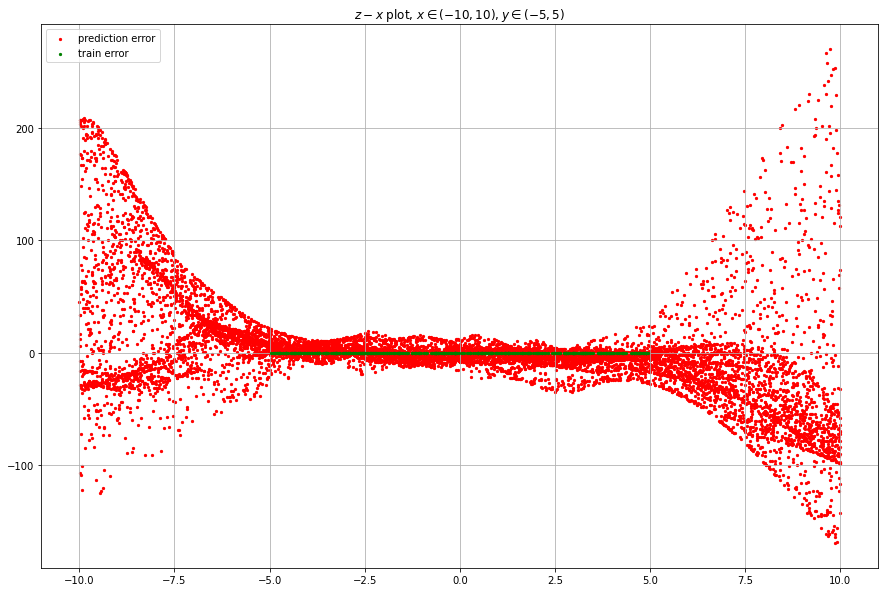

In [225]:
learner.plot_axis(np.random.uniform((-10, -5), (10, 5), (10000, 2)), 0, "$z-x$ plot, $x \\in (-10, 10), y \\in (-5, 5)$")

If we denote the estimated function by $\hat{f}$, the below plot shows $\hat{f}(x, y) - f(x,y)$, where y domain is larger than train domain and x domain is in train domain. (this is because we want check if x is in training domain, what's the effect of changing y on the approximation error.

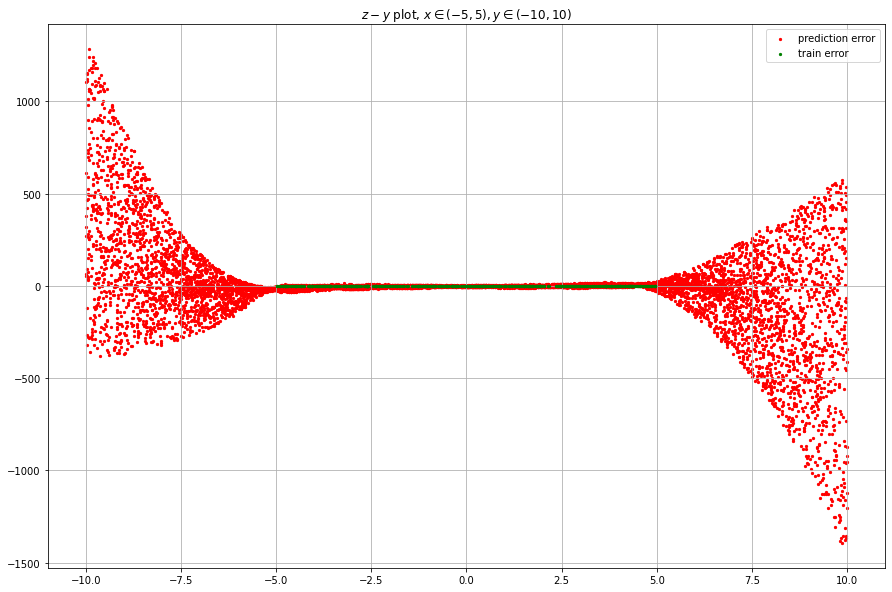

In [226]:
learner.plot_axis(np.random.uniform((-5, -10), (5, 10), (10000, 2)), 1, "$z-y$ plot, $x \\in (-5, 5), y \\in (-10, 10)$")

The error of approximation function in training domain:

In [227]:
learner.error(learner.X)

53.588026365908895

The error of approximation function in a larger domain than training domain:

In [228]:
learner.error(np.random.uniform((-10, -10), (10, 10), (10000, 2)))

172295.02271168432

$$ f(x, y, z) = x \log{y} - z^2 \sin(ye^x) $$

In [242]:
learner = FunctionLearner(
    function=lambda x, y, z: x * np.log(y) - z ** 2 * np.sin(np.exp(x) * y),
    data_size=500,
    train_domain_low=(-5, 0, -5),
    train_domain_high=(5, 10, 5),
    neurons=[55, 28])

In [243]:
learner.learn(500)

epoch:  500 - loss: 7.14681e-03


If we denote the estimated function by $\hat{f}$, the below plot shows $\hat{f}(x, y, z) - f(x, y, z)$, where x domain is larger than train domain and y and z domains are in train domain. (this is because we want check if y and z are in training domain, what's the effect of changing x on the approximation error.

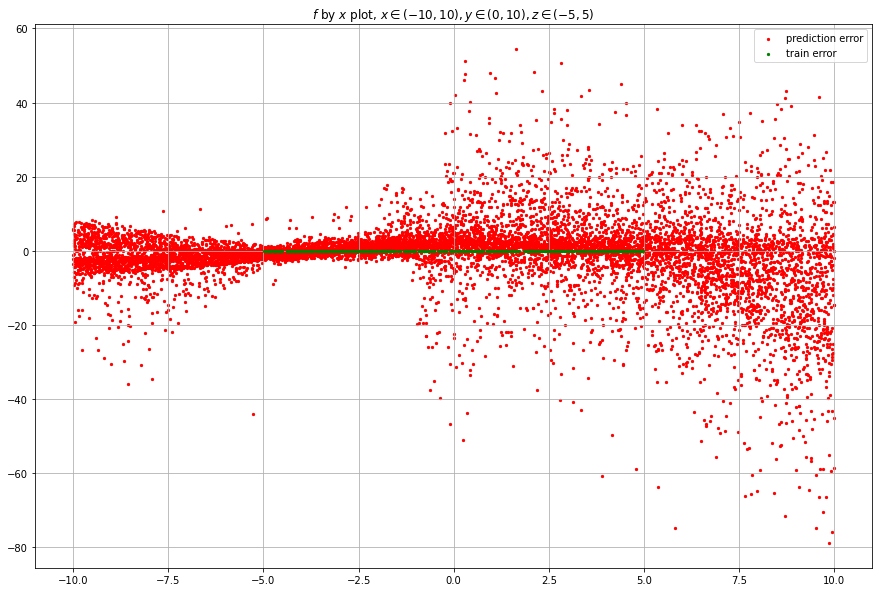

In [244]:
learner.plot_axis(np.random.uniform((-10, 0, -5), (10, 10, 5), (10000, 3)), 0, "$f$ by $x$ plot, $x \\in (-10, 10), y \\in (0, 10), z \\in (-5, 5) $")

If we denote the estimated function by $\hat{f}$, the below plot shows $\hat{f}(x, y, z) - f(x, y, z)$, where y domain is larger than train domain and x and z domains are in train domain. (this is because we want check if x and z are in training domain, what's the effect of changing y on the approximation error.

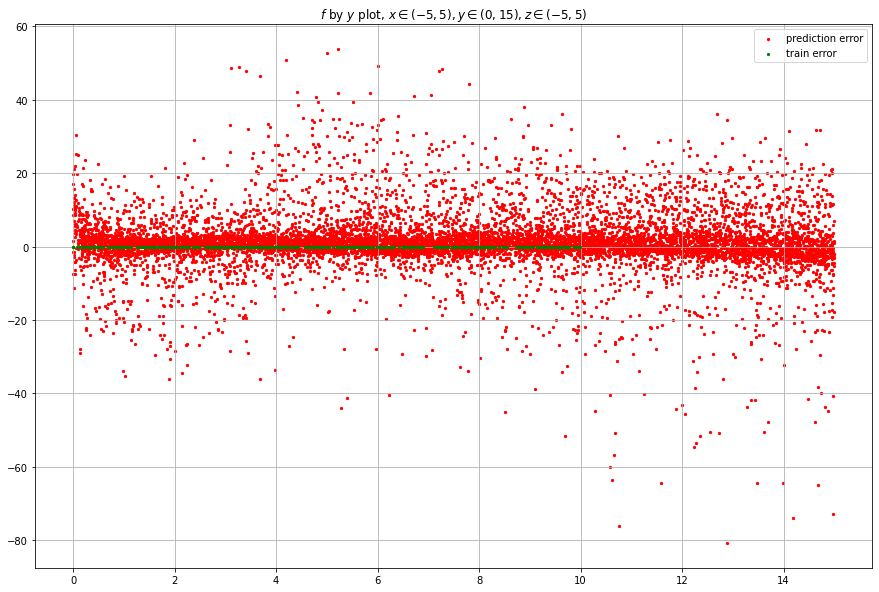

In [245]:
learner.plot_axis(np.random.uniform((-5, 0, -5), (5, 15, 5), (10000, 3)), 1, "$f$ by $y$ plot, $x \\in (-5, 5), y \\in (0, 15), z \\in (-5, 5) $")

If we denote the estimated function by $\hat{f}$, the below plot shows $\hat{f}(x, y, z) - f(x, y, z)$, where z domain is larger than train domain and x and y domains are in train domain. (this is because we want check if x and y are in training domain, what's the effect of changing z on the approximation error.

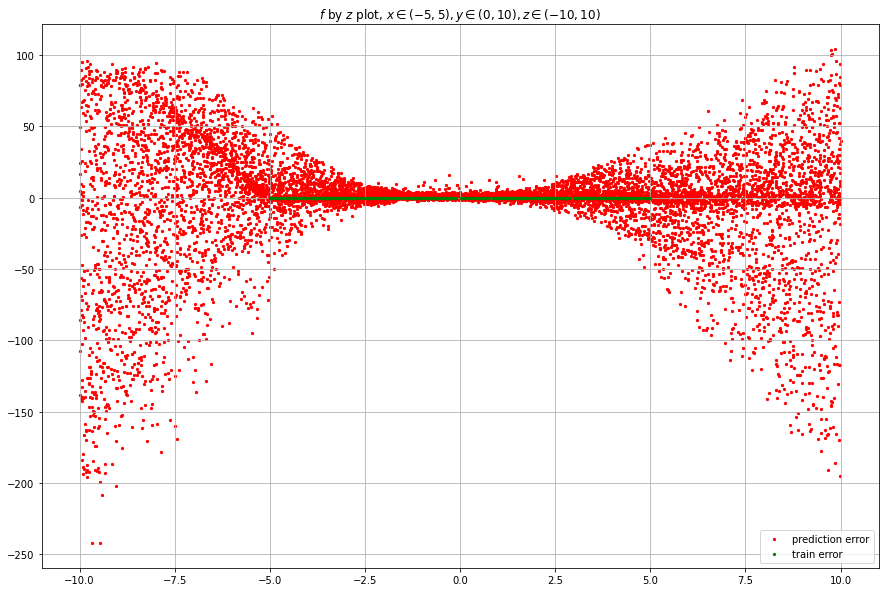

In [246]:
learner.plot_axis(np.random.uniform((-5, 0, -10), (5, 10, 10), (10000, 3)), 2, "$f$ by $z$ plot, $x \\in (-5, 5), y \\in (0, 10), z \\in (-10, 10) $")

The error of approximation function in training domain:

In [247]:
learner.error(learner.X)

18.514636110669738

The error of approximation function in a larger domain than training domain:

In [248]:
learner.error(np.random.uniform((-7, 0, -7), (7, 17, 7), (10000, 3)))

549.2993619455442

### $\S4.$ Approximate a custom function

In this section, an arbitrary curve is drawn by hand and its points are available as an training set.

In [249]:
def plot(df):
    plt.figure(figsize=(15, 10))

    plt.plot(function_points['x'], function_points['y'])

    plt.grid()
    plt.show()

In [250]:
function_points = pd.read_csv('function.csv').drop_duplicates(subset='x')
function_points.head()

x           y
0  74.899994  138.300003
1  75.899994  139.300003
2  76.899994  139.300003
3  77.899994  140.300003
4  79.899994  140.300003

The first curve is as follows:

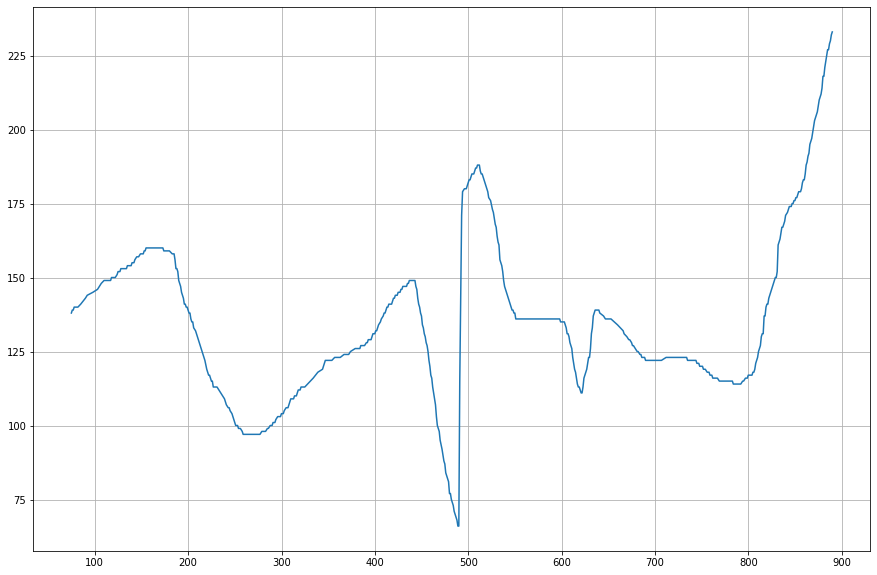

In [251]:
plot(function_points)

In [267]:
learner = FunctionLearner(train_data=function_points, neurons=[25, 25])

In [268]:
learner.learn(500)

epoch:  500 - loss: 1.10155e-02


As can be seen, at points where the function derivative tends to infinity, the model cannot provide an accurate approximation for the curve.

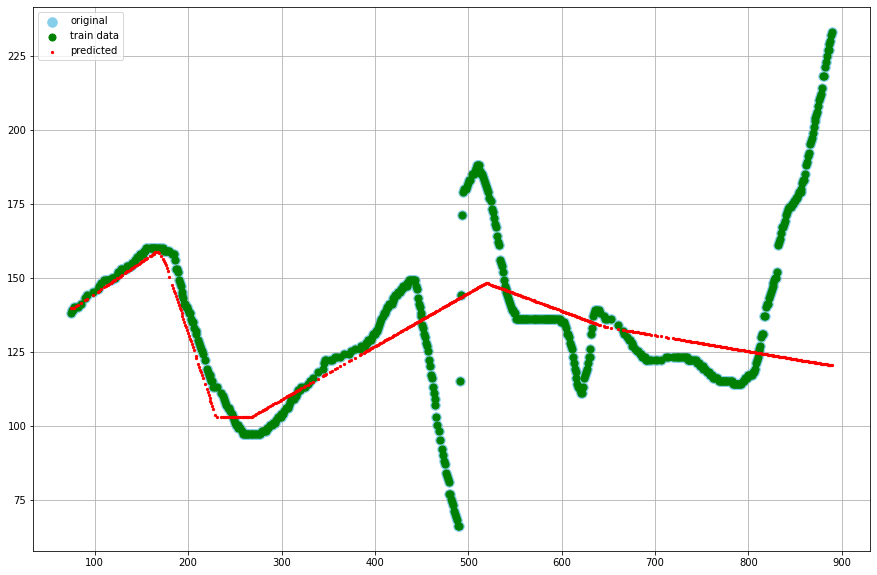

In [269]:
learner.plot_result(learner.X)

In [270]:
function_points = pd.read_csv('function2.csv').drop_duplicates(subset='x').sort_values('x')
function_points.head()

x           y
0  1.899994  331.699982
1  2.899994  331.699982
4  3.899994  332.699982
5  4.899994  332.699982
7  5.899994  333.699982

The second curve is as follows:

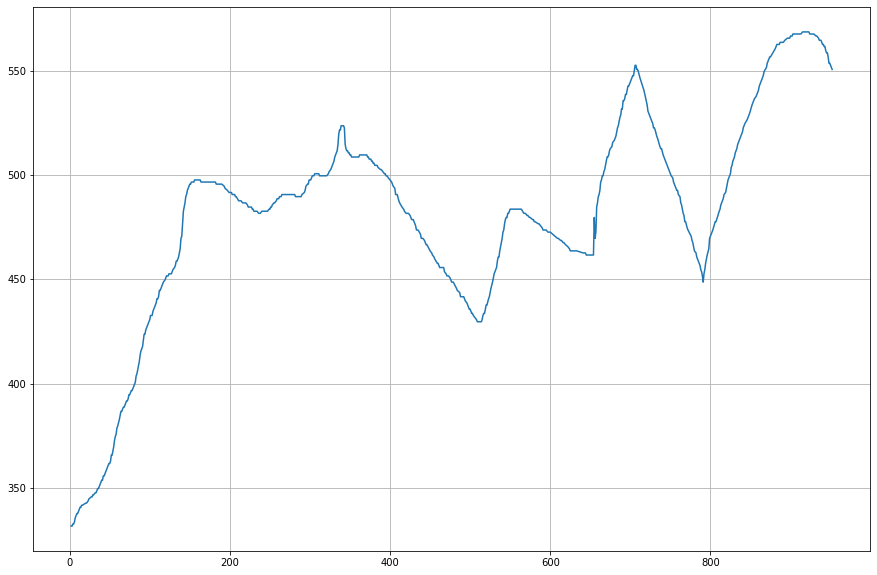

In [271]:
plot(function_points)

In [277]:
learner = FunctionLearner(train_data=function_points, neurons=[40, 40])

In [278]:
learner.learn(500)

epoch:  500 - loss: 1.25835e-03


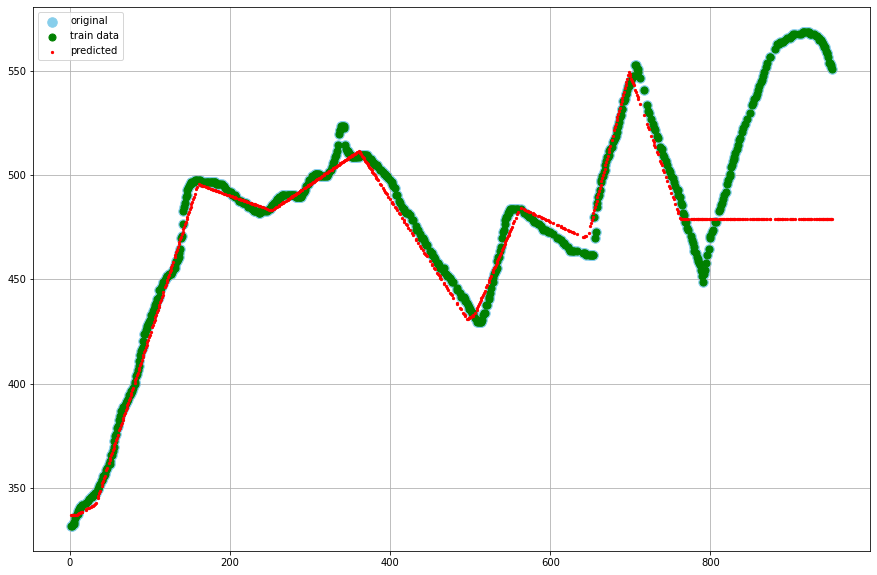

In [279]:
learner.plot_result(learner.X)